<a href="https://colab.research.google.com/github/danielpatrickhug/BLIP2-RAG/blob/main/BLIP2_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Large RAM is required to load the larger models. Running on GPU can optimize inference speed.

In [ ]:
%%bash
python -m spacy download en_core_web_sm

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip install accelerate
    !pip3 install salesforce-lavis
    

In [2]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Feb 10 21:45:02 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P0    58W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import torch
from PIL import Image
import requests
from lavis.models import load_model_and_preprocess

#### Load an example image

In [4]:
# setup device to use
device = torch.device("cuda") if torch.cuda.is_available() else "cpu"

#### Load pretrained/finetuned BLIP2 captioning model

In [ ]:
# we associate a model with its preprocessors to make it easier for inference.
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
)

# Other available models:
# 
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="pretrain_opt6.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt2.7b", is_eval=True, device=device
# )
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_opt", model_type="caption_coco_opt6.7b", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="pretrain_flant5xl", is_eval=True, device=device
# )
#
# model, vis_processors, _ = load_model_and_preprocess(
#     name="blip2_t5", model_type="caption_coco_flant5xl", is_eval=True, device=device
# )

vis_processors.keys()

In [ ]:
model, vis_processors, _ = load_model_and_preprocess(
    name="blip2_t5", model_type="pretrain_flant5xxl", is_eval=True, device=device
)

In [13]:
import spacy
# Load the spaCy NER model
nlp = spacy.load("en_core_web_sm")

In [43]:
import random

def image_retriever(query):
    resp = requests.get(f"https://lexica.art/api/v1/search?q=a photo of a {query} Realistic, High definition, photograph")
    if resp.status_code == 200:
        data = resp.json()

        random_index = random.randint(1, 5)
        first_image = data["images"][random_index]
        img_url = first_image["src"]
        raw_image = Image.open(requests.get(img_url, stream=True).raw).convert('RGB')   
        return raw_image
    else:
        return None


def retrival_augmented_generation(query):
    """
    Given a user query select the best entity/ key phrase to retreive an image from API to answer the question
    """
    #determine best image search query
    # Perform NER on the user query
    doc = nlp(query)

    # Extract named entities from the query
    named_entities = [ent.text for ent in doc.ents]
    # If there are named entities, use the first one as the image search query
    if named_entities:
        print(named_entities[0])
        image_search_query = named_entities[0]
    else:
        # If there are no named entities, use the entire query as the image search query
        image_search_query = query


    raw_image = image_retriever(image_search_query)
    display(raw_image.resize((596, 437)))
    image = vis_processors["eval"](raw_image).unsqueeze(0).to(device)
    
    resp = model.generate({
        "image": image,
        "prompt": f"Question: {query} Answer:"})
    return resp

Wrong here. China maybe has more mountains but not more land area. to the best of my knowledge as of 2023

['China']
China


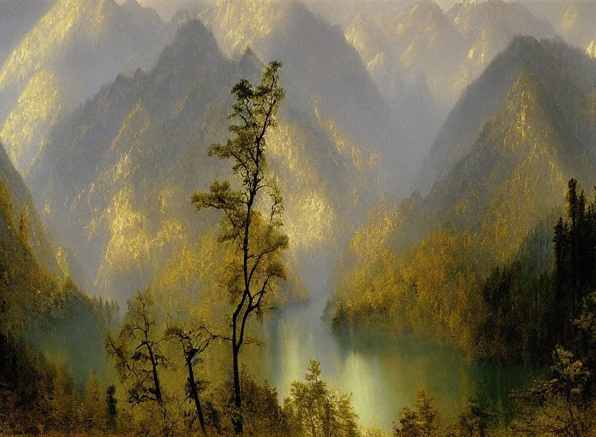

["China is the world's largest country by area"]

In [18]:
retrival_augmented_generation("What is an interesting fact about the China")

Image provided from Switzerland query is a golf course with the alps in the background the model then tells you about their golf courses

['Switzerland']
Switzerland


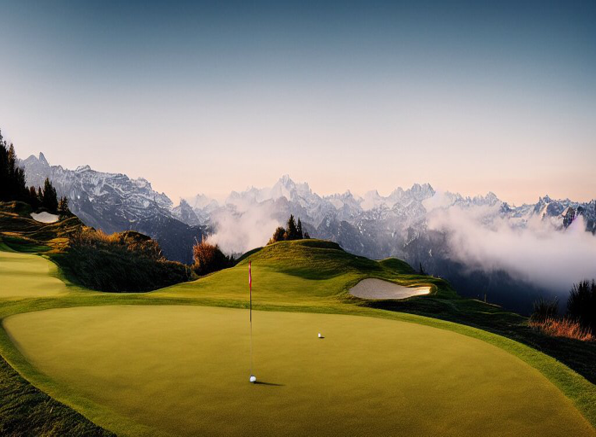

["switzerland is home to some of the world's best golf courses"]

In [19]:
retrival_augmented_generation("What is an interesting fact about Switzerland")

A malamute does look like a siberean husky. Good job Blip

['Malamute']
Malamute


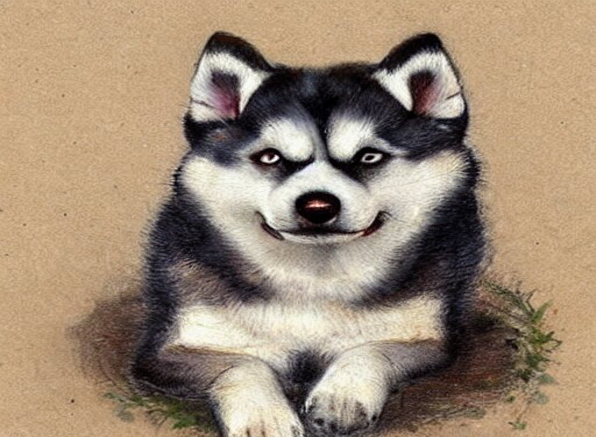

['Siberian husky']

In [21]:
retrival_augmented_generation("What does a Malamute look like?")

Yes, all true

[]


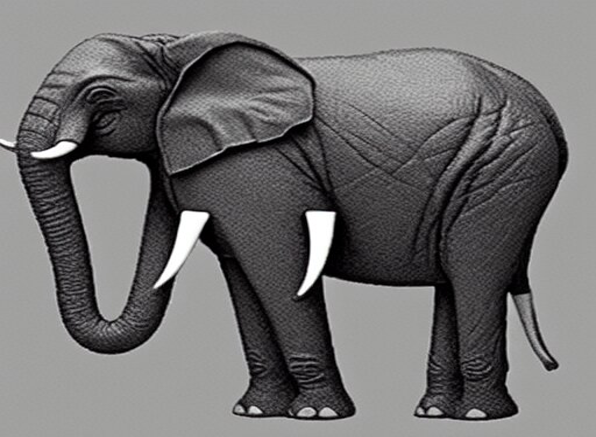

['a large mammal with a trunk and tusks']

In [22]:
retrival_augmented_generation("What does an elephant look like?")

Nice graphs, not wrong

['Quantum Physics']
Quantum Physics


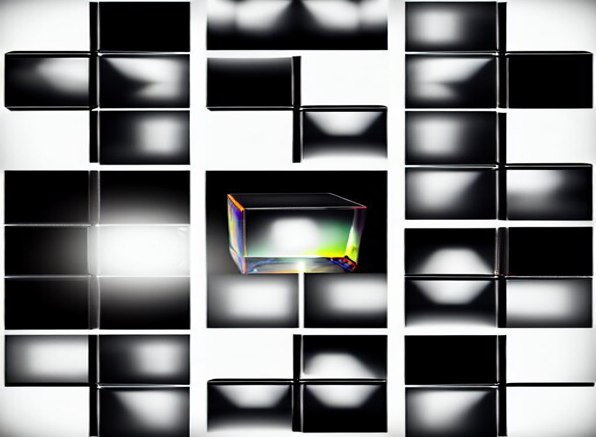

['Quantum physics is the branch of physics that deals with the nature of matter and energy at the atomic and subatomic levels']

In [25]:
retrival_augmented_generation("tell me something about Quantum Physics?")

A "mouse sized" elephant is still larger than mouse.

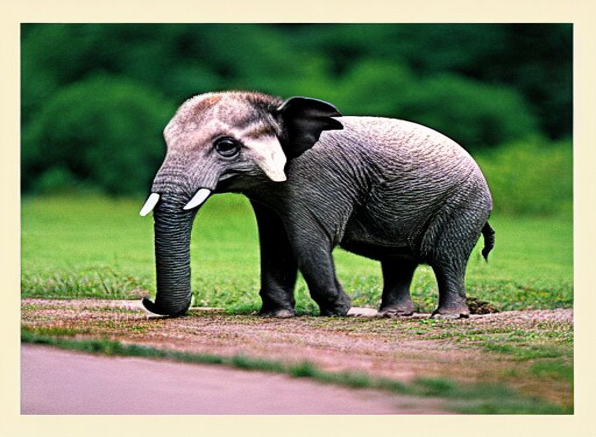

['an elephant']

In [44]:
retrival_augmented_generation("what is larger an elephant or a mouse?")


##NSFW

['Vitruvian']
Vitruvian


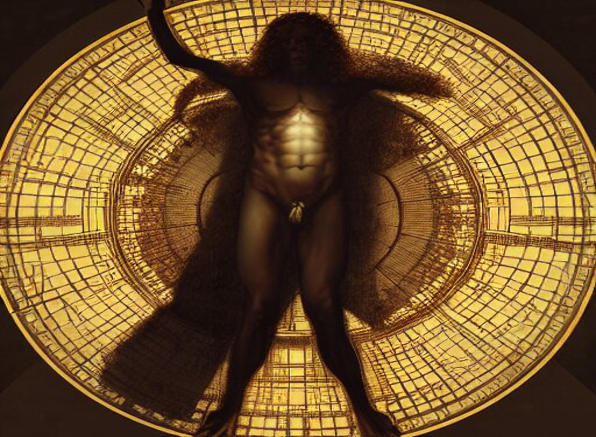

['a naked man standing in the center of a circle']

In [23]:
retrival_augmented_generation("What does the Vitruvian Man look like?")

ChatGPT can you think of a more sophisitcated way of generating image querires

A: Yes, there are several more sophisticated ways to generate image search queries:

Keyword extraction: Instead of named entity recognition, you can use keyword extraction techniques to identify the most relevant keywords in the user query. These keywords can then be used as the image search query.

Query expansion: You can expand the user query by adding synonyms and related terms, which can help to retrieve a more diverse set of images.

Sentiment analysis: You can perform sentiment analysis on the user query to determine if the query is positive, negative, or neutral, and use this information to modify the image search query. For example, if the sentiment is positive, you can search for "beautiful" or "stunning" images, while if the sentiment is negative, you can search for "ugly" or "disappointing" images.

Context-aware image retrieval: You can use additional information about the context of the user query, such as the location, time, and user demographics, to modify the image search query and retrieve more relevant images.

By combining these techniques, you can generate more sophisticated image search queries that are more likely to retrieve the images you're looking for.